### Loading the Cleaned Dataset

In [1]:
import pandas as pd

# Load safely
df_stack = pd.read_csv(
    "stack_overflow_cleaned.csv",
    on_bad_lines='skip',
    encoding='utf-8',
    low_memory=False
)

# Optional: compare with a "raw line count"
!wc -l /content/stack_overflow_cleaned.csv  # Unix: count original lines in file
print("Rows after load:", df_stack.shape[0])


11342 /content/stack_overflow_cleaned.csv
Rows after load: 11341


In [2]:
df_stack.dtypes

,0
Age,object
Employment,object
RemoteWork,object
EdLevel,object
LearnCodeCoursesCert,object
YearsCode,float64
YearsCodePro,float64
DevType,object
OrgSize,object
CompTotal,float64


### Addressing Outliers in CompTotal (Target Variable)

In [3]:
# Step: Filter out unrealistic or extreme salary values from CompTotal
# This helps us understand the distribution of salary values,
# especially the extreme upper percentiles (90th–99.9th)
# Used to justify a statistically sound salary cap (e.g., 500k based on 99th percentile)

df_stack["CompTotal"].describe(percentiles=[.90, .95, .99, .995, .999])


,CompTotal
count,1.134100e+04
mean,8.817566e+11
std,9.390189e+13
min,0.000000e+00
50%,1.500000e+05
90%,2.600000e+05
95%,3.330000e+05
99%,5.500000e+05
99.5%,7.500000e+05
99.9%,1.300000e+06


In [4]:
# Step: Filter out unrealistic salary values before modeling
# Keep only salaries between $5,000 and $500,000 to remove extreme outliers
# This ensures the target distribution is more suitable for regression

df_stack = df_stack[(df_stack["CompTotal"] >= 5000) & (df_stack["CompTotal"] <= 500000)]


In [5]:
import numpy as np

# Step: Compare skewness of raw and log-transformed salary values
# Raw skew helps us see the original distribution shape
# Log-transformed skew helps assess if normalization is beneficial for modeling
raw_skew = df_stack["CompTotal"].skew()
log_skew = np.log1p(df_stack["CompTotal"]).skew()

# Print both for interpretation before deciding on the final target
print(f"Raw CompTotal skew: {raw_skew:.2f}")
print(f"Log-transformed skew: {log_skew:.2f}")

Raw CompTotal skew: 1.43
Log-transformed skew: -0.52


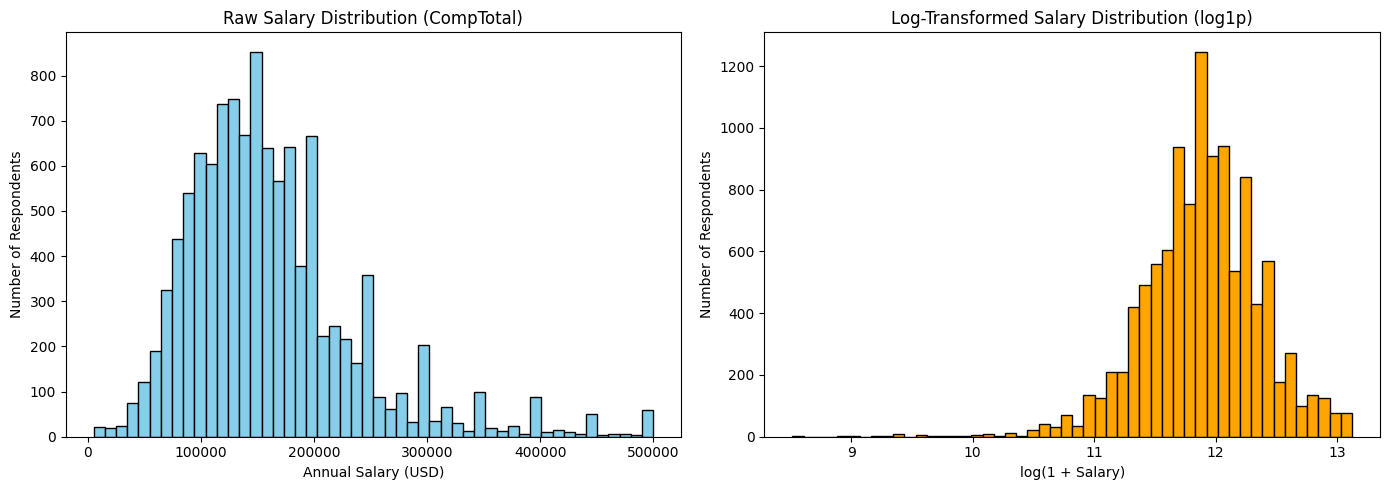

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# TEMP log transform (won’t affect the DataFrame)
log_salaries = np.log1p(df_stack["CompTotal"])

plt.figure(figsize=(14, 5))

# Raw salary histogram
plt.subplot(1, 2, 1)
plt.hist(df_stack["CompTotal"], bins=50, color='skyblue', edgecolor='black')
plt.title("Raw Salary Distribution (CompTotal)")
plt.xlabel("Annual Salary (USD)")
plt.ylabel("Number of Respondents")

# Log-transformed salary histogram
plt.subplot(1, 2, 2)
plt.hist(log_salaries, bins=50, color='orange', edgecolor='black')
plt.title("Log-Transformed Salary Distribution (log1p)")
plt.xlabel("log(1 + Salary)")
plt.ylabel("Number of Respondents")

plt.tight_layout()
plt.show()



The left plot shows the skewed distribution of raw `CompTotal` values.
The right plot shows the normalized shape after applying `log1p()`.

This comparison supports our decision to model both and evaluate performance.

# Feature Engineering

## Goal: Build a strong, simple baseline model
## We will start with :
["Age", "EdLevel", "YearsCodePro", "OrgSize", "RemoteWork", "WorkExp"]


### Encoding EdLevel

In [7]:
# Check for actual NaN values to be sure
nan_count = df_stack["EdLevel"].isna().sum()

# Check for empty strings or strings with only whitespace
blank_count = (df_stack["EdLevel"].str.strip() == "").sum()

print(f"NaN count in EdLevel: {nan_count}")
print(f"Blank/whitespace-only count in EdLevel: {blank_count}")


NaN count in EdLevel: 0
Blank/whitespace-only count in EdLevel: 0


In [8]:
# Double Check the Unique values of EdLevel
print(df_stack['EdLevel'].unique())

['Bachelor’s degree'
 'Some college/university study without earning a degree'
 'Master’s degree' 'Professional degree' 'Secondary school'
 'Associate degree' 'Something else' 'Primary/elementary school']


In [9]:
import numpy as np

# Step 1 – Strip and standardize EdLevel
df_stack["EdLevel"] = df_stack["EdLevel"].str.strip()

# Step 2 – Define ordinal mapping
ed_map = {
    "Primary/elementary school": 0,
    "Secondary school": 1,
    "Some college/university study without earning a degree": 2,
    "Associate degree": 3,
    "Bachelor’s degree": 4,
    "Master’s degree": 5,
    "Professional degree": 6,
    "Something else": np.nan  # we'll treat this as unknown
}

# Step 3 – Apply mapping
df_stack["EdLevel_encoded"] = df_stack["EdLevel"].map(ed_map)

# Step 4 – Inspect
print(df_stack[["EdLevel", "EdLevel_encoded"]].drop_duplicates())


                                               EdLevel  EdLevel_encoded
0                                    Bachelor’s degree              4.0
3    Some college/university study without earning ...              2.0
6                                      Master’s degree              5.0
27                                 Professional degree              6.0
38                                    Secondary school              1.0
39                                    Associate degree              3.0
71                                      Something else              NaN
133                          Primary/elementary school              0.0


### Encoding Employment

In [10]:
print(df_stack["Employment"].unique())

['Employed, full-time'
 'Independent contractor, freelancer, or self-employed'
 'Employed, part-time'
 'Employed, full-time;Independent contractor, freelancer, or self-employed;Employed, part-time'
 'Employed, full-time;Independent contractor, freelancer, or self-employed'
 'Employed, full-time;Employed, part-time' 'I prefer not to say'
 'Independent contractor, freelancer, or self-employed;Retired'
 'Independent contractor, freelancer, or self-employed;Employed, part-time'
 'Independent contractor, freelancer, or self-employed;Employed, part-time;Retired'
 nan 'Employed, full-time;Retired'
 'Employed, full-time;Independent contractor, freelancer, or self-employed;Retired'
 'Retired']


In [11]:
# Step 1: Fill NaN with empty string so we can split safely
df_stack["Employment_clean"] = df_stack["Employment"].fillna("")

# Step 2: Split on ';' and normalize
df_stack["Employment_clean"] = df_stack["Employment_clean"].str.split(";").apply(
    lambda items: [item.strip().lower() for item in items]
)

# Step 3: Create binary indicator columns
df_stack["is_full_time"] = df_stack["Employment_clean"].apply(lambda x: "employed, full-time" in x)
df_stack["is_part_time"] = df_stack["Employment_clean"].apply(lambda x: "employed, part-time" in x)
df_stack["is_self_employed"] = df_stack["Employment_clean"].apply(lambda x: "independent contractor, freelancer, or self-employed" in x)
df_stack["is_retired"] = df_stack["Employment_clean"].apply(lambda x: "retired" in x)

# Optional: Flag if respondent didn't want to say
df_stack["is_employment_unspecified"] = df_stack["Employment_clean"].apply(lambda x: "i prefer not to say" in x)


In [12]:
# Show a sample of the cleaned columns
cols_to_show = ["Employment", "Employment_clean", "is_full_time", "is_part_time", "is_self_employed", "is_retired", "is_employment_unspecified"]
print(df_stack[cols_to_show].head(10))


            Employment       Employment_clean  is_full_time  is_part_time  \
0  Employed, full-time  [employed, full-time]          True         False   
1  Employed, full-time  [employed, full-time]          True         False   
2  Employed, full-time  [employed, full-time]          True         False   
3  Employed, full-time  [employed, full-time]          True         False   
4  Employed, full-time  [employed, full-time]          True         False   
5  Employed, full-time  [employed, full-time]          True         False   
6  Employed, full-time  [employed, full-time]          True         False   
7  Employed, full-time  [employed, full-time]          True         False   
8  Employed, full-time  [employed, full-time]          True         False   
9  Employed, full-time  [employed, full-time]          True         False   

   is_self_employed  is_retired  is_employment_unspecified  
0             False       False                      False  
1             False       Fals

### Encoding RemoteWork

In [13]:
print(df_stack["RemoteWork"].unique())


['Remote' 'Hybrid (some remote, some in-person)' 'In-person' nan]


In [14]:
# Step 1: Fill NA and standardize case
df_stack["RemoteWork_clean"] = df_stack["RemoteWork"].fillna("").str.strip().str.lower()

# Step 2: Create binary flags
df_stack["is_remote"] = df_stack["RemoteWork_clean"] == "remote"
df_stack["is_hybrid"] = df_stack["RemoteWork_clean"] == "hybrid (some remote, some in-person)"
df_stack["is_inperson"] = df_stack["RemoteWork_clean"] == "in-person"

# Step 3: Inspect a few rows
cols_to_show = ["RemoteWork", "RemoteWork_clean", "is_remote", "is_hybrid", "is_inperson"]
print(df_stack[cols_to_show].head(10))


                             RemoteWork                      RemoteWork_clean  \
0                                Remote                                remote   
1  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   
2  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   
3                                Remote                                remote   
4                                Remote                                remote   
5                                Remote                                remote   
6  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   
7  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   
8                                Remote                                remote   
9  Hybrid (some remote, some in-person)  hybrid (some remote, some in-person)   

   is_remote  is_hybrid  is_inperson  
0       True      False        False  
1      False       True       

### Encode DevType

In [15]:
print(df_stack["DevType"].unique())

['Senior Executive (C-Suite, VP, etc.)' 'Developer, back-end'
 'Developer, front-end' 'Developer, full-stack' 'Developer, QA or test'
 'System administrator' 'Database administrator'
 'Developer, desktop or enterprise applications'
 'Data or business analyst' 'Cloud infrastructure engineer'
 'Engineering manager' 'Other (please specify):' 'Developer Experience'
 'Data scientist or machine learning specialist' 'Developer, mobile'
 'Engineer, data' 'Academic researcher'
 'Developer, embedded applications or devices' 'Developer Advocate'
 'Project manager' 'Security professional' 'Hardware Engineer'
 'Developer, game or graphics' 'Product manager' 'DevOps specialist'
 'Research & Development role' 'Engineer, site reliability' 'Designer'
 'Blockchain' 'Scientist' nan 'Marketing or sales professional' 'Educator'
 'Student']


### Since we have a lot of unique values for DevType, we will use the TOP 10 Dev from the EDA

In [16]:
# Fill NaNs and split roles into list
df_stack["DevType_clean"] = df_stack["DevType"].fillna("").apply(
    lambda x: [role.strip() for role in x.split(";")]
)

top_10_roles = [
    'Developer, full-stack',
    'Developer, back-end',
    'Developer, front-end',
    'Developer, desktop or enterprise applications',
    'Engineering manager',
    'Other (please specify):',
    'Developer, embedded applications or devices',
    'Developer, mobile',
    'Cloud infrastructure engineer',
    'Data scientist or machine learning specialist'
]

# Create one-hot (binary) columns for each top role
for role in top_10_roles:
    col_name = f"is_{role.lower().replace(',', '').replace(' ', '_').replace('-', '_')}"
    df_stack[col_name] = df_stack["DevType_clean"].apply(lambda roles: role in roles)

# Show the sample
cols_to_show = ["DevType"] + [f"is_{role.lower().replace(',', '').replace(' ', '_').replace('-', '_')}" for role in top_10_roles]
df_stack[cols_to_show].head(10)


,DevType,is_developer_full_stack,is_developer_back_end,is_developer_front_end,is_developer_desktop_or_enterprise_applications,is_engineering_manager,is_other_(please_specify):,is_developer_embedded_applications_or_devices,is_developer_mobile,is_cloud_infrastructure_engineer,is_data_scientist_or_machine_learning_specialist
0,"Senior Executive (C-Suite, VP, etc.)",False,False,False,False,False,False,False,False,False,False
1,"Developer, back-end",False,True,False,False,False,False,False,False,False,False
2,"Developer, front-end",False,False,True,False,False,False,False,False,False,False
3,"Developer, full-stack",True,False,False,False,False,False,False,False,False,False
4,"Developer, full-stack",True,False,False,False,False,False,False,False,False,False
5,"Developer, full-stack",True,False,False,False,False,False,False,False,False,False
6,"Developer, QA or test",False,False,False,False,False,False,False,False,False,False
7,"Developer, full-stack",True,False,False,False,False,False,False,False,False,False
8,"Developer, front-end",False,False,True,False,False,False,False,False,False,False
9,System administrator,False,False,False,False,False,False,False,False,False,False


### Encoding OrgSize

In [17]:
# Step 1: Inspect unique values
print(df_stack["OrgSize"].unique())


['2-9' '5,000-9,999' '100-499' '1,000-4,999' '10-19' '10,000 or more'
 '500-999' '20-99' 'Just me - I am a freelancer, sole proprietor, etc.'
 'I don’t know' nan]


In [18]:
# Step 2: Define ordinal mapping for OrgSize
orgsize_map = {
    "Just me - I am a freelancer, sole proprietor, etc.": 0,
    "1-9": 1,
    "2-9": 1,  # handling possible variations
    "10-19": 2,
    "20-99": 3,
    "100-499": 4,
    "500-999": 5,
    "1,000-4,999": 6,
    "5,000-9,999": 7,
    "10,000 or more": 8,
    "I don’t know": np.nan  # treat "don't know" as missing
}

# Step 3: Apply the mapping
df_stack["OrgSize_encoded"] = df_stack["OrgSize"].map(orgsize_map)

# Step 4: Inspect results
print(df_stack[["OrgSize", "OrgSize_encoded"]].drop_duplicates())


                                                OrgSize  OrgSize_encoded
0                                                   2-9              1.0
1                                           5,000-9,999              7.0
2                                               100-499              4.0
3                                           1,000-4,999              6.0
4                                                 10-19              2.0
6                                        10,000 or more              8.0
12                                              500-999              5.0
21                                                20-99              3.0
22    Just me - I am a freelancer, sole proprietor, ...              0.0
117                                        I don’t know              NaN
4868                                                NaN              NaN


We will be keeping the Nan value for now and handle it later

### One-Hot Encoding Multi-Select Tech Stack Columns
### LanguageHaveWorkedWith, DatabaseHaveWorkedWith, PlatformHaveWorkedWith
These are all multi-select fields (like DevType).


In [19]:
from collections import Counter

def process_multiselect_column(df, col_name, top_n=10):
    # Step 1: Clean and split
    clean_col = f"{col_name}_clean"
    df[clean_col] = df[col_name].fillna("").apply(lambda x: [item.strip() for item in x.split(";")])

    # Step 2: Count top N
    counter = Counter([item for sublist in df[clean_col] for item in sublist])
    top_items = [item for item, _ in counter.most_common(top_n)]

    # Step 3: Create binary columns
    for item in top_items:
        safe_col = f"{col_name}_{item.lower().replace(' ', '_').replace('-', '_').replace('+', '_').replace('.', '').replace(',', '')}"
        df[safe_col] = df[clean_col].apply(lambda x: item in x)

    return top_items


In [20]:
# Get top 10 most common items

columns_to_process = [
    "LanguageHaveWorkedWith",
    "DatabaseHaveWorkedWith",
    "PlatformHaveWorkedWith",
    "WebframeHaveWorkedWith",
    "MiscTechHaveWorkedWith",
    "ToolsTechHaveWorkedWith"
]

for col in columns_to_process:
    top = process_multiselect_column(df_stack, col)
    print(f"Top for {col}:", top)


Top for LanguageHaveWorkedWith: ['JavaScript', 'SQL', 'HTML/CSS', 'Python', 'TypeScript', 'Bash/Shell (all shells)', 'C#', 'Java', 'PowerShell', 'C++']
Top for DatabaseHaveWorkedWith: ['PostgreSQL', 'MySQL', 'Microsoft SQL Server', 'SQLite', 'Redis', 'MongoDB', 'Elasticsearch', 'Dynamodb', '', 'MariaDB']
Top for PlatformHaveWorkedWith: ['Amazon Web Services (AWS)', 'Microsoft Azure', 'Google Cloud', '', 'Cloudflare', 'Digital Ocean', 'Heroku', 'Firebase', 'Vercel', 'Netlify']
Top for WebframeHaveWorkedWith: ['React', 'Node.js', '', 'jQuery', 'ASP.NET CORE', 'Angular', 'ASP.NET', 'Express', 'Next.js', 'Vue.js']
Top for MiscTechHaveWorkedWith: ['', '.NET (5+)', '.NET Framework (1.0 - 4.8)', 'Pandas', 'NumPy', 'Apache Kafka', 'Spring Framework', 'RabbitMQ', 'Scikit-Learn', 'React Native']
Top for ToolsTechHaveWorkedWith: ['Docker', 'npm', 'Homebrew', 'Pip', 'Kubernetes', 'Webpack', 'Yarn', 'Make', 'NuGet', 'Terraform']


One-Hot Encode Multi-Select Tech Stack Columns

In [21]:
import pandas as pd

# Create dictionary of top 10 items per column
top_tech = {}
for col in columns_to_process:
    top_tech[col] = process_multiselect_column(df_stack, col)


for col, top_values in top_tech.items():
    df_stack[col + "_clean"] = df_stack[col].fillna("").apply(lambda x: [item.strip() for item in x.split(";")])

    # Build all binary columns first
    binary_cols = {}
    for tech in top_values:
        clean_col_name = f"{col}_{tech}".replace(" ", "_").replace("(", "").replace(")", "").replace("-", "_").replace("/", "").replace(".", "").replace("+", "plus").replace("–", "").replace(",", "").replace("'", "").replace("__", "_")
        binary_cols[clean_col_name] = df_stack[col + "_clean"].apply(lambda x: tech in x)

    # Efficiently add all new columns at once
    df_stack = pd.concat([df_stack, pd.DataFrame(binary_cols)], axis=1)


In [22]:
# List all generated binary columns for DatabaseHaveWorkedWith, WebframeHaveWorkedWith, ToolsTechHaveWorkedWith
db_cols = [col for col in df_stack.columns if col.startswith('DatabaseHaveWorkedWith_')]
webframe_cols = [col for col in df_stack.columns if col.startswith('WebframeHaveWorkedWith_')]
tools_cols = [col for col in df_stack.columns if col.startswith('ToolsTechHaveWorkedWith_')]
print('DatabaseHaveWorkedWith columns:', db_cols)
print('WebframeHaveWorkedWith columns:', webframe_cols)
print('ToolsTechHaveWorkedWith columns:', tools_cols)

DatabaseHaveWorkedWith columns: ['DatabaseHaveWorkedWith_clean', 'DatabaseHaveWorkedWith_postgresql', 'DatabaseHaveWorkedWith_mysql', 'DatabaseHaveWorkedWith_microsoft_sql_server', 'DatabaseHaveWorkedWith_sqlite', 'DatabaseHaveWorkedWith_redis', 'DatabaseHaveWorkedWith_mongodb', 'DatabaseHaveWorkedWith_elasticsearch', 'DatabaseHaveWorkedWith_dynamodb', 'DatabaseHaveWorkedWith_', 'DatabaseHaveWorkedWith_mariadb', 'DatabaseHaveWorkedWith_PostgreSQL', 'DatabaseHaveWorkedWith_MySQL', 'DatabaseHaveWorkedWith_Microsoft_SQL_Server', 'DatabaseHaveWorkedWith_SQLite', 'DatabaseHaveWorkedWith_Redis', 'DatabaseHaveWorkedWith_MongoDB', 'DatabaseHaveWorkedWith_Elasticsearch', 'DatabaseHaveWorkedWith_Dynamodb', 'DatabaseHaveWorkedWith_', 'DatabaseHaveWorkedWith_MariaDB']
WebframeHaveWorkedWith columns: ['WebframeHaveWorkedWith_clean', 'WebframeHaveWorkedWith_react', 'WebframeHaveWorkedWith_nodejs', 'WebframeHaveWorkedWith_', 'WebframeHaveWorkedWith_jquery', 'WebframeHaveWorkedWith_aspnet_core', 'Webf

In [23]:
# Pick one processed column group to preview
example_col = "LanguageHaveWorkedWith"

# Print a few of the binary columns generated
print([col for col in df_stack.columns if col.startswith(example_col)])

# Display a few rows of just those columns
cols_to_show = [col for col in df_stack.columns if col.startswith(example_col)]
print(df_stack[cols_to_show].head(10))


['LanguageHaveWorkedWith', 'LanguageHaveWorkedWith_clean', 'LanguageHaveWorkedWith_javascript', 'LanguageHaveWorkedWith_sql', 'LanguageHaveWorkedWith_html/css', 'LanguageHaveWorkedWith_python', 'LanguageHaveWorkedWith_typescript', 'LanguageHaveWorkedWith_bash/shell_(all_shells)', 'LanguageHaveWorkedWith_c#', 'LanguageHaveWorkedWith_java', 'LanguageHaveWorkedWith_powershell', 'LanguageHaveWorkedWith_c__', 'LanguageHaveWorkedWith_JavaScript', 'LanguageHaveWorkedWith_SQL', 'LanguageHaveWorkedWith_HTMLCSS', 'LanguageHaveWorkedWith_Python', 'LanguageHaveWorkedWith_TypeScript', 'LanguageHaveWorkedWith_BashShell_all_shells', 'LanguageHaveWorkedWith_C#', 'LanguageHaveWorkedWith_Java', 'LanguageHaveWorkedWith_PowerShell', 'LanguageHaveWorkedWith_Cplusplus']
                              LanguageHaveWorkedWith  \
0                         HTML/CSS;JavaScript;Python   
1                         Bash/Shell (all shells);Go   
2  Bash/Shell (all shells);HTML/CSS;JavaScript;PH...   
3  Ada;Clojure;El

### Modeling  Plan :
Model A - CompTotal
Model B - LogCompTotal

## Prepare Baseline Feature Set for Modeling

This step we will drop unused columns and keep only the features needed for the baseline model.

In [24]:
# Define final baseline features (make sure these are all created already)
baseline_features = [
    "Age",
    "EdLevel_encoded",
    "YearsCodePro",
    "OrgSize",
    "WorkExp",
    "is_remote",
    "is_hybrid",
    "is_inperson"
]

# Drop rows with any missing values in these features
df_baseline = df_stack[baseline_features].dropna()

# Show result summary
print(" Final Baseline Dataset Shape:", df_baseline.shape)
print(df_baseline.head())


 Final Baseline Dataset Shape: (7856, 8)
     Age  EdLevel_encoded  YearsCodePro      OrgSize  WorkExp  is_remote  \
0  25-34              4.0           9.0          2-9     10.0       True   
1  45-54              4.0          23.0  5,000-9,999     23.0      False   
2  25-34              4.0           7.0      100-499      7.0      False   
3  35-44              2.0           3.0  1,000-4,999      4.0       True   
4  25-34              4.0           3.0        10-19      5.0       True   

   is_hybrid  is_inperson  
0      False        False  
1       True        False  
2       True        False  
3      False        False  
4      False        False  


In [25]:
# Ensure Age_encoded exists in df_stack for enhanced modeling
age_map = {
    "Under 18": 0,
    "18-24": 1,
    "25-34": 2,
    "35-44": 3,
    "45-54": 4,
    "55-64": 5,
    "65 or older": 6
}
df_stack["Age_encoded"] = df_stack["Age"].map(age_map)
print("Created Age_encoded in df_stack. Unique values:", df_stack["Age_encoded"].unique())

Created Age_encoded in df_stack. Unique values: [ 2.  4.  3.  5.  1. nan  0.]


In [26]:
# Map Age brackets to integers
age_map = {
    "Under 18": 0,
    "18-24": 1,
    "25-34": 2,
    "35-44": 3,
    "45-54": 4,
    "55-64": 5,
    "65 or older": 6
}
df_baseline["Age_encoded"] = df_baseline["Age"].map(age_map)

# Map OrgSize to ordered scale
orgsize_map = {
    "Just me": 0,
    "2-9": 1,
    "10-19": 2,
    "20-99": 3,
    "100-499": 4,
    "500-999": 5,
    "1,000-4,999": 6,
    "5,000-9,999": 7,
    "10,000 or more": 8
}
df_baseline["OrgSize_encoded"] = df_baseline["OrgSize"].map(orgsize_map)

# Drop original categorical columns
df_baseline.drop(["Age", "OrgSize"], axis=1, inplace=True)

# Inspect
print(" Encoded dataset ready:")
print(df_baseline.head())


 Encoded dataset ready:
   EdLevel_encoded  YearsCodePro  WorkExp  is_remote  is_hybrid  is_inperson  \
0              4.0           9.0     10.0       True      False        False   
1              4.0          23.0     23.0      False       True        False   
2              4.0           7.0      7.0      False       True        False   
3              2.0           3.0      4.0       True      False        False   
4              4.0           3.0      5.0       True      False        False   

   Age_encoded  OrgSize_encoded  
0          2.0              1.0  
1          4.0              7.0  
2          2.0              4.0  
3          3.0              6.0  
4          2.0              2.0  


In [27]:
# Target: Compensation

# Match target to baseline features
y = df_stack.loc[df_baseline.index, "CompTotal"]


# Final features from df_baseline
X = df_baseline.copy()


In [28]:
from sklearn.model_selection import train_test_split

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Confirm shapes
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (6284, 8)
Test shape: (1572, 8)


#  Baseline Regression with Raw Target (No Hyperparameter Tuning)

### We'll use this for its robustness and minimal need for feature scaling.

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [30]:
# Predict
y_pred = model.predict(X_test)


In [35]:
# Evaluate
mae_rf = mean_absolute_error(y_test, y_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred))
r2_rf = r2_score(y_test, y_pred)

print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R² Score: {r2_rf:.4f}")

MAE: 53151.00
RMSE: 72627.84
R² Score: 0.0693


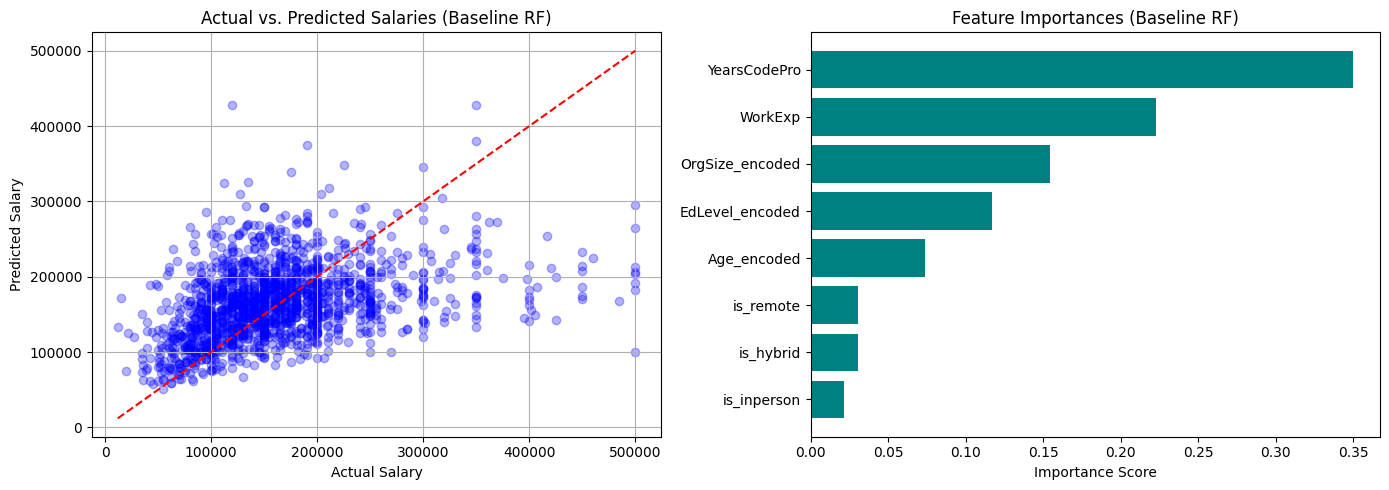

In [31]:
# Baseline Random Forest: Actual vs Predicted and Feature Importances
import matplotlib.pyplot as plt

# Actual vs Predicted
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (Baseline RF)")
plt.grid(True)

# Feature Importances
plt.subplot(1, 2, 2)
importances = model.feature_importances_
feature_names = X.columns
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='teal')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Baseline RF)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Hyperparameter Tuning for Random Forest (Same Baseline Feature)

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define hyperparameter grid for Random Forest tuning
# Includes variations in tree count, depth, splitting rules, and feature selection strategy
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize base model
rf = RandomForestRegressor(random_state=42)

# Grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=2)

# Fit
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Use X_test not y_test
y_pred_best = best_rf.predict(X_test)

# Evaluation
mae_tuned = mean_absolute_error(y_test, y_pred_best)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_best))
r2_tuned = r2_score(y_test, y_pred_best)

print(f"Best Params: {grid_search.best_params_}")
print(f"MAE: {mae_tuned:.2f}")
print(f"RMSE: {rmse_tuned:.2f}")
print(f"R² Score: {r2_tuned:.4f}")


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
MAE: 47972.72
RMSE: 66790.65
R² Score: 0.2129


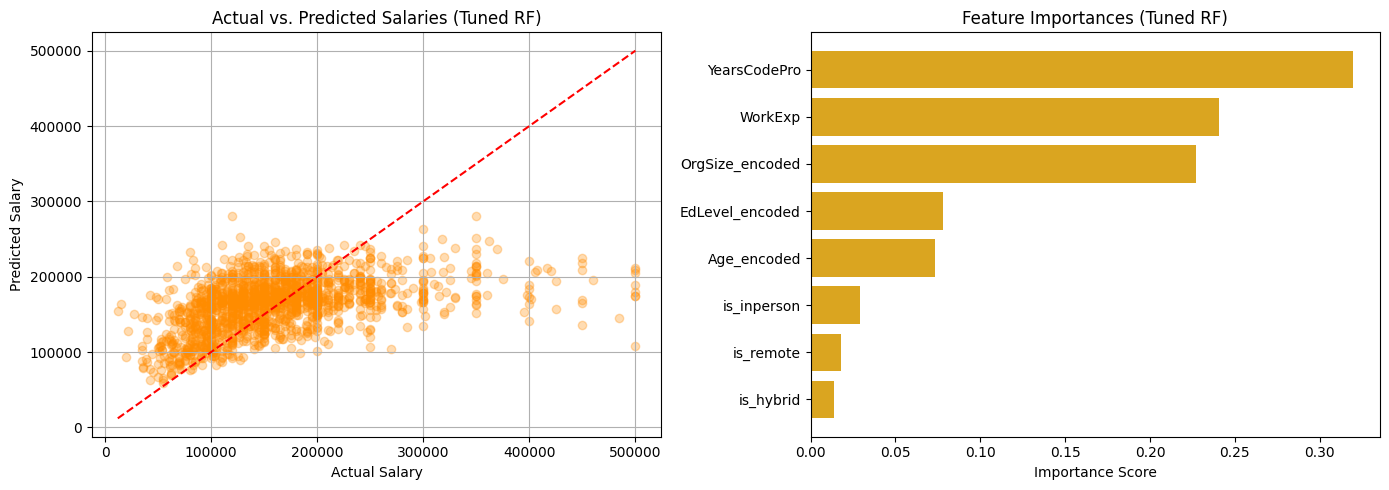

In [37]:
# Tuned Random Forest

# Actual vs Predicted

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_best, alpha=0.3, color='darkorange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (Tuned RF)")
plt.grid(True)

# Feature Importances

plt.subplot(1, 2, 2)
importances = best_rf.feature_importances_
feature_names = X_train.columns
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='goldenrod')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Tuned RF)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#RandomForrest Regression with Logarithmic Transformation of Target


In [38]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 1. Set up features and log-transformed target
X = df_baseline.copy()
y = df_stack.loc[df_baseline.index, 'CompTotal']
y_log = np.log1p(y)  # log1p handles 0 or small values safely

# 2. Split into train/test
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# 3. Train a model (Random Forest as example)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train_log)

# 4. Predict (log scale), then revert back using expm1
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)        # Inverse of log1p
y_test_actual = np.expm1(y_test_log) # Inverse of log1p

# 5. Evaluation
mae_log = mean_absolute_error(y_test_actual, y_pred)
rmse_log = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2_log = r2_score(y_test_actual, y_pred)

# 6. Output
print("Log-Transformed Target Evaluation:")
print(f"MAE: {mae_log:,.2f}")
print(f"RMSE: {rmse_log:,.2f}")
print(f"R² Score: {r2_log:.4f}")


Log-Transformed Target Evaluation:
MAE: 51,125.14
RMSE: 71,753.56
R² Score: 0.0916


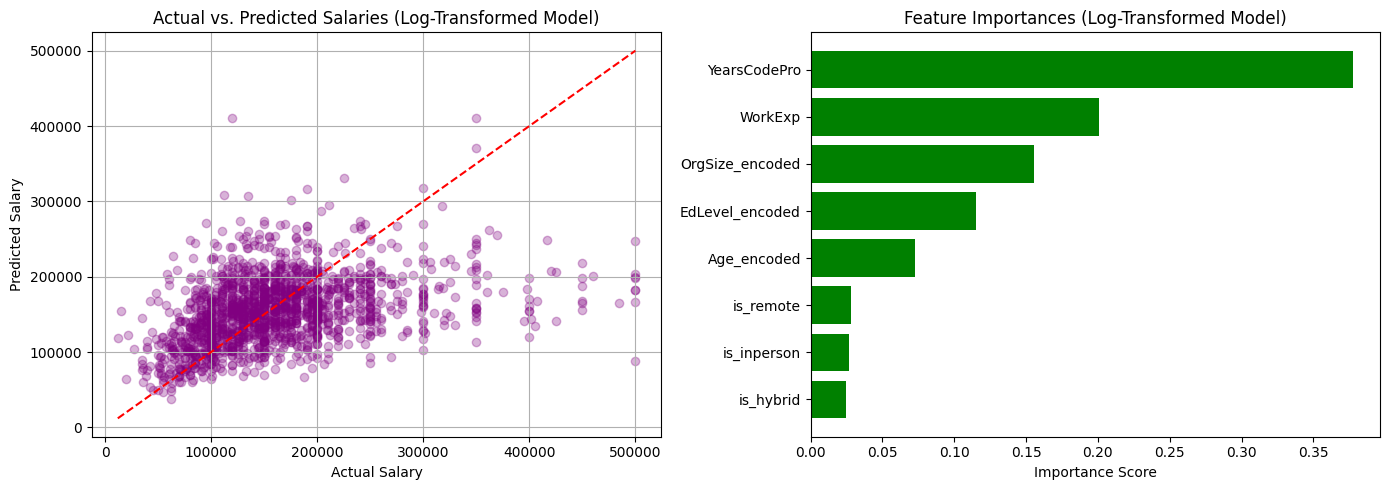

In [39]:
# Log-Transformed Model: Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test_actual, y_pred, alpha=0.3, color='purple')
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], '--', color='red')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (Log-Transformed Model)")
plt.grid(True)

#  Feature Importances
plt.subplot(1, 2, 2)
importances = model.feature_importances_
feature_names = X.columns
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='green')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Log-Transformed Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Feature Expansion with Tuning


### This is just a diagnostic step to check if there are missing enhanced features

In [40]:
# Diagnostic: Check for missing enhanced features before modeling
enhanced_features = [
    'Age_encoded',
    'EdLevel_encoded',
    'YearsCodePro',
    'OrgSize_encoded',
    'WorkExp',
    'is_remote',
    'is_hybrid',
    'is_inperson',
    'is_full_time',
    'is_developer_full_stack',
    'LanguageHaveWorkedWith_Python',
    # Top 10 DatabaseHaveWorkedWith
    'DatabaseHaveWorkedWith_MySQL',
    'DatabaseHaveWorkedWith_PostgreSQL',
    'DatabaseHaveWorkedWith_SQL_Server',
    'DatabaseHaveWorkedWith_SQLite',
    'DatabaseHaveWorkedWith_MongoDB',
    'DatabaseHaveWorkedWith_Oracle',
    'DatabaseHaveWorkedWith_Redis',
    'DatabaseHaveWorkedWith_Firebase',
    'DatabaseHaveWorkedWith_Elasticsearch',
    'DatabaseHaveWorkedWith_MariaDB',
    # Top 10 WebframeHaveWorkedWith
    'WebframeHaveWorkedWith_React',
    'WebframeHaveWorkedWith_Angular',
    'WebframeHaveWorkedWith_Vue_js',
    'WebframeHaveWorkedWith_Django',
    'WebframeHaveWorkedWith_Flask',
    'WebframeHaveWorkedWith_Express',
    'WebframeHaveWorkedWith_Laravel',
    'WebframeHaveWorkedWith_Ruby_on_Rails',
    'WebframeHaveWorkedWith_Spring',
    'WebframeHaveWorkedWith_Next_js',
    # Top 10 ToolsTechHaveWorkedWith
    'ToolsTechHaveWorkedWith_Docker',
    'ToolsTechHaveWorkedWith_Git',
    'ToolsTechHaveWorkedWith_Kubernetes',
    'ToolsTechHaveWorkedWith_Jenkins',
    'ToolsTechHaveWorkedWith_AWS',
    'ToolsTechHaveWorkedWith_Azure',
    'ToolsTechHaveWorkedWith_Google_Cloud_Platform',
    'ToolsTechHaveWorkedWith_GitHub_Actions',
    'ToolsTechHaveWorkedWith_Ansible',
    'ToolsTechHaveWorkedWith_Terraform'
 ]

missing_cols = [col for col in enhanced_features if col not in df_stack.columns]
if missing_cols:
    print('Missing columns:', missing_cols)
    print('All columns in df_stack:')
    print(df_stack.columns.tolist())
    print('Sample of df_stack:')
    display(df_stack.head())
else:
    print('All enhanced features are present!')

Missing columns: ['DatabaseHaveWorkedWith_SQL_Server', 'DatabaseHaveWorkedWith_Oracle', 'DatabaseHaveWorkedWith_Firebase', 'WebframeHaveWorkedWith_Vue_js', 'WebframeHaveWorkedWith_Django', 'WebframeHaveWorkedWith_Flask', 'WebframeHaveWorkedWith_Laravel', 'WebframeHaveWorkedWith_Ruby_on_Rails', 'WebframeHaveWorkedWith_Spring', 'WebframeHaveWorkedWith_Next_js', 'ToolsTechHaveWorkedWith_Git', 'ToolsTechHaveWorkedWith_Jenkins', 'ToolsTechHaveWorkedWith_AWS', 'ToolsTechHaveWorkedWith_Azure', 'ToolsTechHaveWorkedWith_Google_Cloud_Platform', 'ToolsTechHaveWorkedWith_GitHub_Actions', 'ToolsTechHaveWorkedWith_Ansible']
All columns in df_stack:
['Age', 'Employment', 'RemoteWork', 'EdLevel', 'LearnCodeCoursesCert', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize', 'CompTotal', 'LanguageHaveWorkedWith', 'DatabaseHaveWorkedWith', 'PlatformHaveWorkedWith', 'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'ToolsTechHaveWorkedWith', 'NEWCollabToolsHaveWorkedWith', 'OpSysPersonal use', 'OpSysProfes

,Age,Employment,RemoteWork,EdLevel,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,CompTotal,...,ToolsTechHaveWorkedWith_npm,ToolsTechHaveWorkedWith_Homebrew,ToolsTechHaveWorkedWith_Pip,ToolsTechHaveWorkedWith_Kubernetes,ToolsTechHaveWorkedWith_Webpack,ToolsTechHaveWorkedWith_Yarn,ToolsTechHaveWorkedWith_Make,ToolsTechHaveWorkedWith_NuGet,ToolsTechHaveWorkedWith_Terraform,Age_encoded
0,25-34,"Employed, full-time",Remote,Bachelor’s degree,Other,18.0,9.0,"Senior Executive (C-Suite, VP, etc.)",2-9,285000.0,...,True,False,True,True,True,True,False,False,False,2.0
1,45-54,"Employed, full-time","Hybrid (some remote, some in-person)",Bachelor’s degree,NaN,27.0,23.0,"Developer, back-end","5,000-9,999",250000.0,...,False,False,False,True,False,False,True,False,False,4.0
2,25-34,"Employed, full-time","Hybrid (some remote, some in-person)",Bachelor’s degree,NaN,12.0,7.0,"Developer, front-end",100-499,156000.0,...,True,True,False,False,True,True,False,False,False,2.0
3,35-44,"Employed, full-time",Remote,Some college/university study without earning ...,Udemy,4.0,3.0,"Developer, full-stack","1,000-4,999",135000.0,...,True,True,False,True,False,True,True,False,False,3.0
4,25-34,"Employed, full-time",Remote,Bachelor’s degree,Codecademy;edX,5.0,3.0,"Developer, full-stack",10-19,80000.0,...,True,True,True,False,False,False,True,False,False,2.0


### Training The Model

In [44]:
# --- Enhanced Feature Set: Add three new features ---
enhanced_features = [
    'Age_encoded',
    'EdLevel_encoded',
    'YearsCodePro',
    'OrgSize_encoded',
    'WorkExp',
    'is_remote',
    'is_hybrid',
    'is_inperson',
    'is_full_time',
    'is_developer_full_stack',
    'LanguageHaveWorkedWith_Python',

    # Top 10 most common databases used
    'DatabaseHaveWorkedWith_PostgreSQL',
    'DatabaseHaveWorkedWith_MySQL',
    'DatabaseHaveWorkedWith_Microsoft_SQL_Server',
    'DatabaseHaveWorkedWith_SQLite',
    'DatabaseHaveWorkedWith_Redis',
    'DatabaseHaveWorkedWith_MongoDB',
    'DatabaseHaveWorkedWith_Elasticsearch',
    'DatabaseHaveWorkedWith_Dynamodb',
    'DatabaseHaveWorkedWith_MariaDB'
]


# Ensure all features exist and drop rows with missing values
df_enhanced = df_stack.copy()
missing_cols = [col for col in enhanced_features if col not in df_enhanced.columns]
if missing_cols:
    print('Missing columns:', missing_cols)
    print('All columns in df_stack:')
    print(df_enhanced.columns.tolist())
    raise ValueError('Some required features are missing from the DataFrame. Please check the feature engineering steps above.')

df_enhanced = df_enhanced[enhanced_features + ['CompTotal']].dropna()

# Features and target
X_enhanced = df_enhanced[enhanced_features]
y_enhanced = df_enhanced['CompTotal']

# Train/test split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X_enhanced, y_enhanced, test_size=0.2, random_state=42
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_rf.predict(X_test)
mae_exp = mean_absolute_error(y_test, y_pred)
rmse_exp = mean_squared_error(y_test, y_pred) ** 0.5  # Fix: remove 'squared' argument
r2_exp = r2_score(y_test, y_pred)

print('Best Params:', grid_search.best_params_)
print(f'MAE: {mae_exp:,.2f}')
print(f'RMSE: {rmse_exp:,.2f}')
print(f'R² Score: {r2_exp:.4f}')


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
MAE: 44,557.68
RMSE: 62,605.76
R² Score: 0.2839


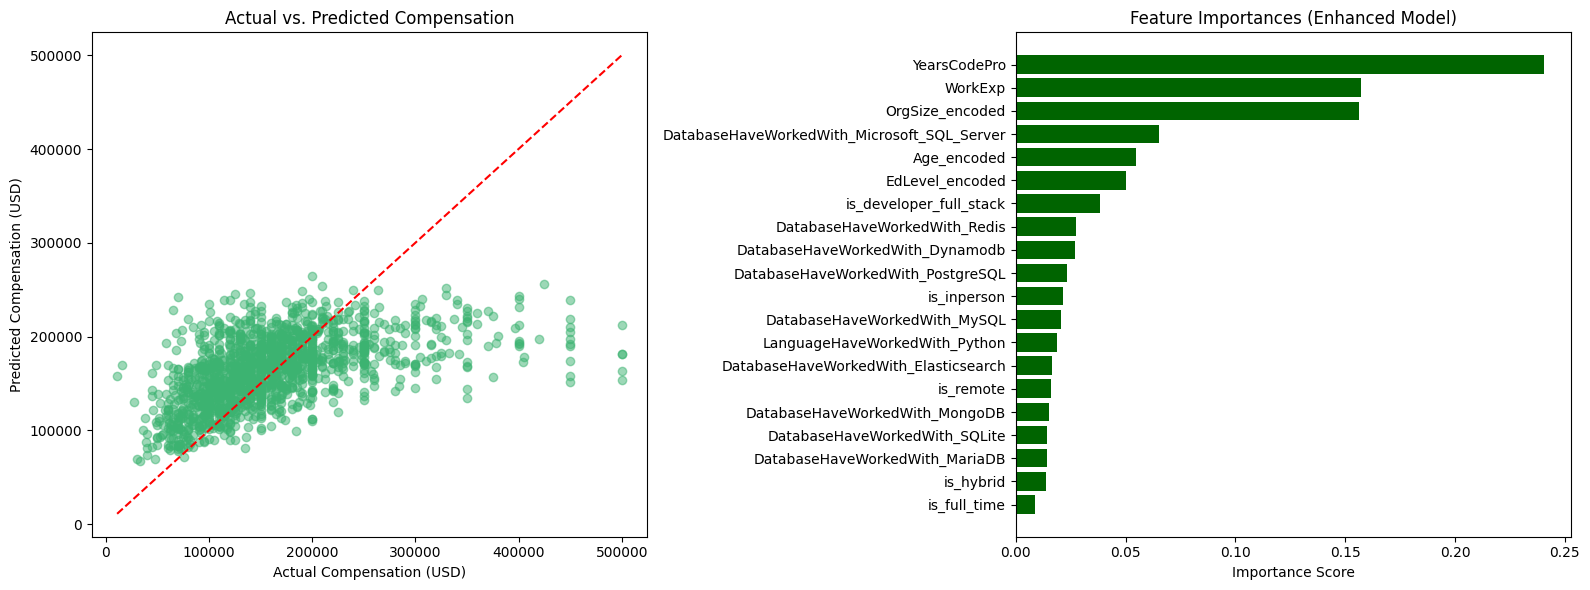

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Feature Importances ---
importances = best_rf.feature_importances_
feat_names = X_enhanced.columns

# Create a DataFrame sorted by importance
feat_imp_df = pd.DataFrame({
    'Feature': feat_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: Actual vs. Predicted Scatter Plot
axes[0].scatter(y_test, y_pred, alpha=0.5, color='mediumseagreen')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel('Actual Compensation (USD)')
axes[0].set_ylabel('Predicted Compensation (USD)')
axes[0].set_title('Actual vs. Predicted Compensation')

#  Right Plot: Feature Importances
axes[1].barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='darkgreen')
axes[1].invert_yaxis()  # Highest importance at the top
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Feature Importances (Enhanced Model)')

# Final layout adjustments
plt.tight_layout()
plt.show()


#Gradient Boosting


In [47]:
#  Gradient Boosting Regressor: Train and Evaluate on Enhanced Features

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize and train the model
gbr_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
gbr_model.fit(X_train, y_train)

# Predict on test set
y_pred_gbr = gbr_model.predict(X_test)

# Evaluate model performance
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = mean_squared_error(y_test, y_pred_gbr) ** 0.5
r2_gbr = r2_score(y_test, y_pred_gbr)

# Print results
print('Gradient Boosting Results:')
print(f'MAE: {mae_gbr:,.2f}')
print(f'RMSE: {rmse_gbr:,.2f}')
print(f'R² Score: {r2_gbr:.4f}')


Gradient Boosting Results:
MAE: 44,394.30
RMSE: 62,115.12
R² Score: 0.2951


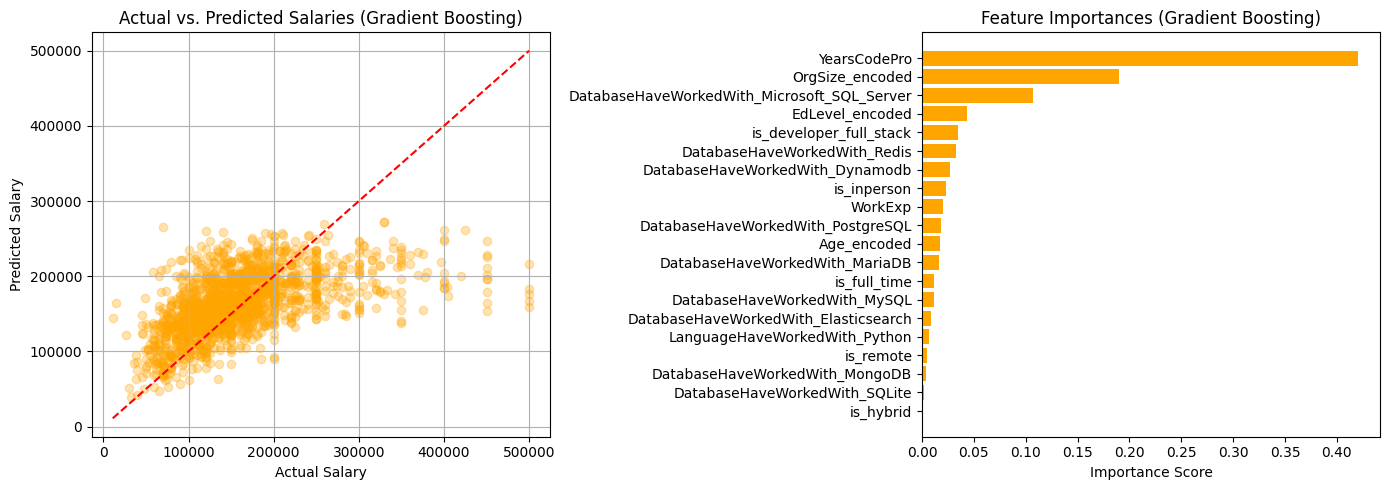

In [48]:
# Gradient Boosting:

# Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_gbr, alpha=0.3, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs. Predicted Salaries (Gradient Boosting)")
plt.grid(True)

# Feature Importances
plt.subplot(1, 2, 2)
importances = gbr.feature_importances_
feature_names = X_train.columns
feat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.barh(feat_importance_df['Feature'], feat_importance_df['Importance'], color='orange')
plt.xlabel('Importance Score')
plt.title('Feature Importances (Gradient Boosting)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Overall Table Comparison

In [51]:
import pandas as pd

# Construct the evaluation table using values from the provided image
model_results = pd.DataFrame({
    "Model": [
        "Gradient Boosting",
        "Feature Expansion with Tuning",
        "Random Forest (Log Transform, No Tuning)",
        "Hyperparameter Tuning for Random Forest",
        "Baseline Random Forest"
    ],
    "MAE": [
        44394.30,
        44557.68,
        51125.14,
        47972.72,
        53151.00
    ],
    "RMSE": [
        62115.12,
        62605.76,
        71753.56,
        66790.65,
        72627.00
    ],
    "R2": [
        0.2951,
        0.2839,
        0.0916,
        0.2129,
        0.0693
    ]
})

# Sort models by R² score (optional for display)
model_results = model_results.sort_values(by="R2", ascending=False).reset_index(drop=True)

# Display rounded results
model_results.round(2)


,Model,MAE,RMSE,R2
0,Gradient Boosting,44394.30,62115.12,0.30
1,Feature Expansion with Tuning,44557.68,62605.76,0.28
2,Hyperparameter Tuning for Random Forest,47972.72,66790.65,0.21
3,"Random Forest (Log Transform, No Tuning)",51125.14,71753.56,0.09
4,Baseline Random Forest,53151.00,72627.00,0.07
